In other simulations, we could start the population death alelles already set to something other than the 0 vector and see if this changes anything.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
'''
Lets set the amount of Loci per alelle to 5 and lets do it on a grid with periodic conditions (torus) of 20x20. 
T=1 for us, this is the generations that takes for the "target" phenotype of reproduction. 
That is, in every generation an entry changes from 0 to 1 or vice versa. 
For the single point recombination, lets say that we partition the alelles at 4, 
then for the reproduction alelles we take loci 1-4 from parent 1 and 5-10 from parent 2. 
And for the death alelles we do the opposite, take 1-4 from parent 2 and 5-10 from parent 1. 
If we don't have single point recombination, we just take reproduction from parent 1 and death from parent 2. 
Due to the lack of time and computing power, we will just evaluate the case where the reproduction is asexual. We will comment on the paper some of the results 
the paper has to offer about the sexual case. 
'''
class Bacterium:
    count = 0  # Iterator for unique IDs
    d_0 = 0.2 #accidental death rate/baseline death rate
    p_f = 0.01 #probability of bit-flip mutations of offsprings
    p_a = 0.01 #probability of bit-flip mutations of offsprings 
    b = 1.2 #baseline fitness
    T = 1 #number of generations before it changes
    a = 5 #amount of alleles
    
    def __init__(self, rep_al, mort_al, age=0, lansing=False):
        self.id = Bacterium.count  # Unique identity for each bacterium
        Bacterium.count += 1
        self.age = age #This is going to be integers as we are in a discrete time case. 
        self.rep = rep_al
        self.mort = mort_al
        self.lansing = lansing

    #define representation
    def __repr__(self):
        return f'id: {self.id}, age: {self.age}'


def update_age(population):
    for i in range(len(population)):
        for j in range(len(population)):
            population[i, j].age += 1

#simulation, can we make bacterium into a data type
def simulate(size, max_time, selection='non directional'):
    events = []
    ageing = [] #this will give the loci of a newborn, we have it to keep track of where it is evolving to. 
    fecundity = []
    means = []
    corr = []

    time = 0
    if selection == 'directional':
        tar_phen = np.zeros(Bacterium.a, dtype=int) #target phenotype
        filling = True  #this is a "switch" to change from 1->0 or 0->1s
        zeros_indices = set(range(Bacterium.a))
        ones_indices = set()

    else:
        tar_phen = np.random.randint(2, size=Bacterium.a)
    # population initialisation, we will store in a size x size numpy matrix
    population = np.zeros((size, size), dtype=object) 
    
    for i in range(size):
        for j in range(size):
            rand = np.random.randint(0, np.floor(1/Bacterium.d_0) + 1) #initialises a random age for the initial population
            
            #All individuals are initiated with all death loci being 0, and Unif(0, 1) alleles for the reproduction:
            population[i, j] = Bacterium(np.random.randint(2, size=Bacterium.a), np.zeros(Bacterium.a, dtype=int), rand) 
            
    #We will use mod(% operator) to simulate the torus. -1 mod N = N - 1 (last element as indexes are -1), then we also have 20 % 20 = 0, 
    #so if we're on the last index, going one further takes us to the first:
    while time < max_time: 
        i = np.random.randint(0, size)
        j = np.random.randint(0, size) #creates 2 indexes

        if population[i, j] is not None: #if the site is ocuppied
            rand = np.random.rand()
            death_prob = min(Bacterium.d_0 + 0.1 * np.sum(population[i, j].mort)*population[i, j].age, 1) #We may change the 0.01 to something larger
            if rand <= death_prob: #they die
                population[i, j] = None
                events.append('death at time {} and position {}'.format(time, [i, j]))
        else:
            #Logic for reproduction
            N = size #more readable
            possible = [[(i+1) % N, j], [i, (j+1)% N], [(i+1)% N, (j+1)% N], [(i-1)% N, (j-1)% N], [(i-1)% N, j], [i, (j-1)% N], [(i-1)% N, (j+1)% N], [(i+1)% N, (j-1)% N]]
            prob_list = []
            new_possible = []
            for [temp1, temp2] in possible:
                if population[temp1, temp2] is not None:
                    prob_list.append(Bacterium.b ** (population[temp1, temp2].rep @ tar_phen))
                    new_possible.append([temp1, temp2])
                    
            possible = new_possible
            prob_list = np.array(prob_list)/np.sum(prob_list)

            if len(possible) == 0:
                continue #if no parents, we jump to next iteration
            
            index = np.random.choice(range(len(possible)), p = prob_list)
            [m, n] = possible[index]
            off_rep = []
            off_mort = []
            for allele in population[m, n].rep:
                rand = np.random.rand()
                if rand < Bacterium.p_f:
                    off_rep.append(-allele + 1)
                else: 
                    off_rep.append(allele)
            for allele in population[m, n].mort:
                rand = np.random.rand()
                if rand < Bacterium.p_a:
                    off_mort.append(-allele + 1)
                else:
                    off_mort.append(allele)
            population[i, j] = Bacterium(off_rep, off_mort)
            ageing.append(off_mort)
            fecundity.append(off_rep)
            events.append('birth at time {} and position {}'.format(time, [i, j]))
            
        time += 1

        
        if selection == 'directional': #implementing logic to do the directional selection
            if filling:
                if zeros_indices:
                    idx = np.random.choice(list(zeros_indices))
                    tar_phen[idx] = 1
                    zeros_indices.remove(idx)
                    ones_indices.add(idx)
                else:
                    filling = False  # switch to emptying phase
            else:
                if ones_indices:
                    idx = np.random.choice(list(ones_indices))
                    tar_phen[idx] = 0
                    ones_indices.remove(idx)
                    zeros_indices.add(idx)
                else:
                    filling = True  # switch back to filling

        count = 0
        age = 0
        alpha = 0
        mort = 0
        fecun = 0
        alpha_list = []
        rep_list = []
        if time % (size**2) == 0:
            for i in population.copy().flatten():
                if i is not None:
                    age+=i.age
                    alpha += 0.1 * np.sum(i.mort)
                    alpha_list.append(0.01 * np.sum(i.mort))
                    mort += min(Bacterium.d_0 + 0.1 * np.sum(i.mort)*i.age, 1)
                    fecun += Bacterium.b ** (i.rep @ tar_phen) / Bacterium.b**5
                    rep_list.append(Bacterium.b ** (i.rep @ tar_phen) / Bacterium.b**5)
                    count +=1
    
            #update age 
            for i in range(size):
                for j in range(size):
                    if population[i, j] is not None:
                        population[i, j].age += 1

            #find correlation
            correlation = np.corrcoef(alpha_list, rep_list)
            corr.append(correlation[0, 1])
            
            means.append([age/count, alpha/count, mort/count, fecun/count]) #means gives a mean of the value in the population at a given time t. 

    return population, fecundity, ageing, means, corr, events


#update age, remember to update phenotype if its directional

In [175]:
pop, xbs, xds, means, events = simulate(10, 600000, selection='non directional')
pop1, xbs1, xds1, means1, events1 = simulate(10, 600000, selection='directional')

[2, 5, 2, 2, 4, 11, 5, 5, 4, 3, 3, 1, 3, 1, 10, 1, 4, 2, 7, 5, 4, 1, 1, 5, 2, 1, 5, 13, 6, 10, 4, 8, 6, 2, 7, 1, 13, 4, 1, 1, 23, 10, 2, 3, 2, 5, 2, 2, 6, 7, 1, 8, 1, 11, 5, 3, 5, 2, 6, 1, 5, 1, 2, 6, 5, 2, 10, 3, 8, 2, 7, 2, 16, 6, 14, 6, 2, 1, 3, 3, 2, 4, 2, 5, 13, 3]


(array([41., 19., 11.,  3.,  6.,  4.,  1.,  0.,  0.,  1.]),
 array([ 1. ,  3.2,  5.4,  7.6,  9.8, 12. , 14.2, 16.4, 18.6, 20.8, 23. ]),
 <BarContainer object of 10 artists>)

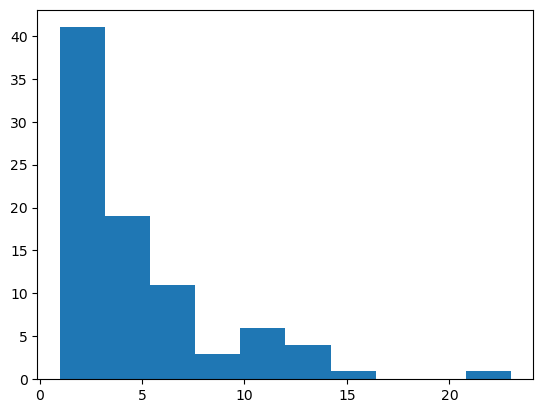

In [176]:
age_dist = []
for i in pop.flatten():
        if i is not None:
            age_dist.append(i.age)
print((age_dist))
plt.hist(age_dist)

[4, 10, 1, 5, 1, 11, 1, 3, 8, 9, 5, 2, 10, 2, 5, 3, 5, 1, 9, 1, 7, 2, 2, 5, 3, 2, 2, 1, 5, 7, 2, 5, 2, 5, 2, 4, 1, 13, 2, 3, 4, 3, 2, 1, 1, 1, 3, 10, 3, 1, 1, 5, 1, 2, 2, 3, 6, 2, 2, 2, 1, 1, 6, 30, 12, 2, 3, 4, 2, 5, 5, 3, 4, 3, 8, 11, 3, 4, 8, 4, 2, 4, 12, 8, 2, 1, 15, 4, 1]


(array([49., 22.,  8.,  7.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ]),
 <BarContainer object of 10 artists>)

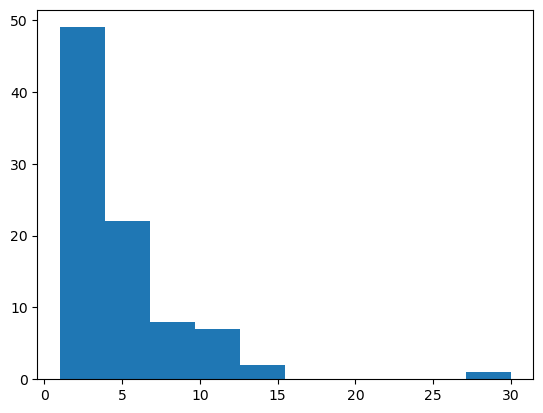

In [177]:
age_dist1 = []
for i in pop1.flatten():
        if i is not None:
            age_dist1.append(i.age)
print((age_dist1))
plt.hist(age_dist1)

2000

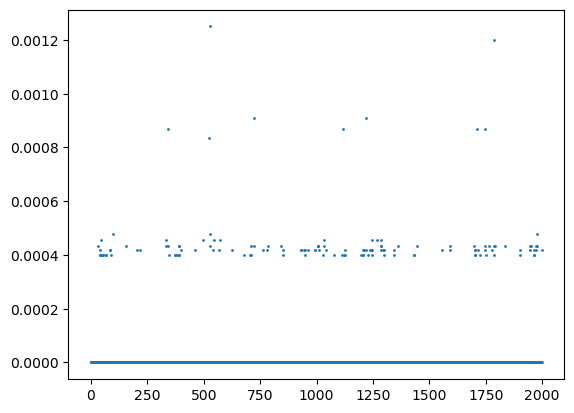

In [142]:
plt.scatter(range(len(means)), np.array(means)[:,1], s=1)
len(means)

In [138]:
pop

array([[id: 9583, age: 11634, id: 10144, age: 826, id: 9694, age: 9439,
        id: 10186, age: 107, id: 10147, age: 791, id: 10069, age: 2560,
        id: 10103, age: 1786, id: 10134, age: 1070, id: 10162, age: 534,
        id: 10066, age: 2605],
       [id: 10166, age: 474, id: 9992, age: 3771, None,
        id: 10057, age: 2723, id: 10137, age: 1030, id: 10158, age: 587,
        id: 10124, age: 1270, id: 10155, age: 664, id: 10023, age: 3269,
        None],
       [id: 10112, age: 1548, id: 10071, age: 2514, id: 10151, age: 748,
        id: 10117, age: 1439, id: 10132, age: 1163, id: 10174, age: 262,
        id: 10113, age: 1480, None, id: 10139, age: 970,
        id: 10142, age: 859],
       [id: 10184, age: 118, id: 10053, age: 2812, id: 10073, age: 2487,
        id: 10181, age: 134, None, id: 10136, age: 1050,
        id: 10131, age: 1170, id: 10070, age: 2534, id: 10119, age: 1367,
        id: 9869, age: 6435],
       [id: 10105, age: 1760, id: 10157, age: 615, id: 10048, age: 2

In [66]:
age_dist = []
for _ in range(10):
    pop, xbs, xds, means, events = simulate(10, 600000, selection='non directional')
    for i in pop.flatten():
        if i is not None:
            age_dist.append(i.age)

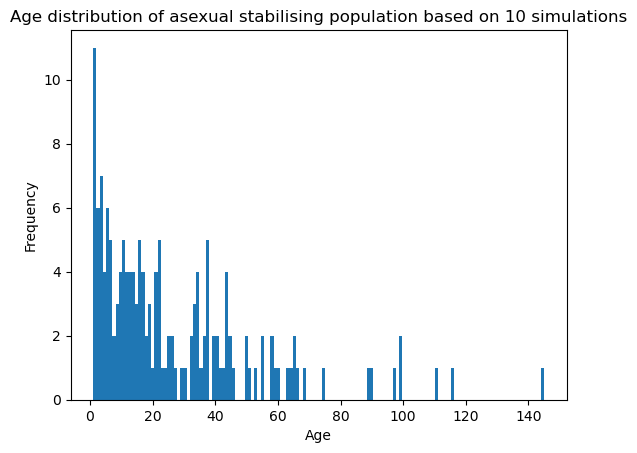

In [83]:
# plt.plot(np.mean(xds, axis=1)[::10])
plt.hist(age_dist, bins=140)
plt.title('Age distribution of asexual stabilising population based on 10 simulations')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.savefig('stabilising age distribution for 10x10 latice after 6000 generations.jpg')

In [68]:
age_dist1 = []
for _ in range(10):
    pop1, xbs1, xds1, means1, events1 = simulate(10, 600000, selection='directional')
    for i in pop1.flatten():
        if i is not None:
            age_dist1.append(i.age)

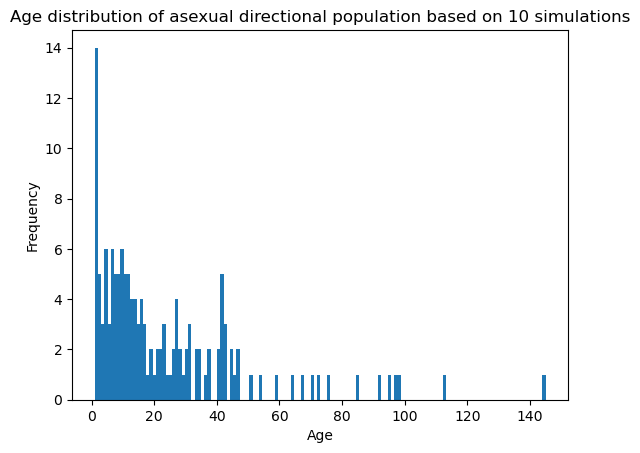

In [80]:
plt.hist(age_dist1, bins=140)
plt.title('Age distribution of asexual directional population based on 10 simulations')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.savefig('directional age distribution for 10x10 latice after 6000 generations.jpg')

In [ ]:
#Show the above histograms as proportions. Or calculate the proportions so that 

# A partir de aquí vamos a hacer todas los calculos de szilagyi, creo que lo de arriba esta mal.

In [207]:
#Here we find the means in the population and the evolution of xbs and xds for stabilising populations using 10 simulations. 
age_dist = []
means_directional = []
xbs_directional = []
xds_directional = []
correlation = []
for _ in range(10):
    pop, xbs, xds, means, corr, events = simulate(10, 600000, selection='non directional')
    for i in pop.flatten():
        if i is not None:
            age_dist.append(i.age)
    means_directional.append(means)
    xbs_directional.append(xbs)
    xds_directional.append(xds)
    correlation.append(corr)

/Users/zhangyuli/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/zhangyuli/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [278]:
#We will now see the mean of 10 simulations in the directional case:
age_dist1 = []
means_directional1 = []
xbs_directional1 = []
xds_directional1 = []
correlation1 = []
for _ in range(10):
    pop1, xbs1, xds1, means1, corr1, events1 = simulate(10, 600000, selection='directional')
    for i in pop1.flatten():
        if i is not None:
            age_dist1.append(i.age)
    means_directional1.append(means1)
    xbs_directional1.append(xbs1)
    xds_directional1.append(xds1)
    correlation1.append(corr1)

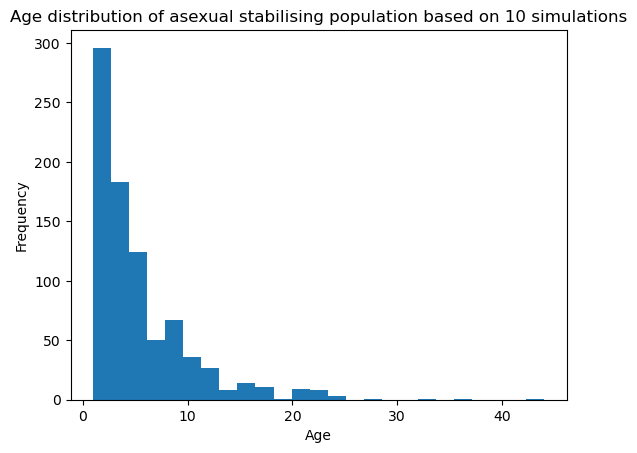

In [300]:
# plt.plot(np.mean(xds, axis=1)[::10])
plt.hist(age_dist, bins=25)
plt.title('Age distribution of asexual stabilising population based on 10 simulations')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.savefig('stabilising age distribution for 10x10 latice after 6000 generations, el bueno.jpg')

In [315]:
#Make the age_dist into proportions
print(xds)

[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 

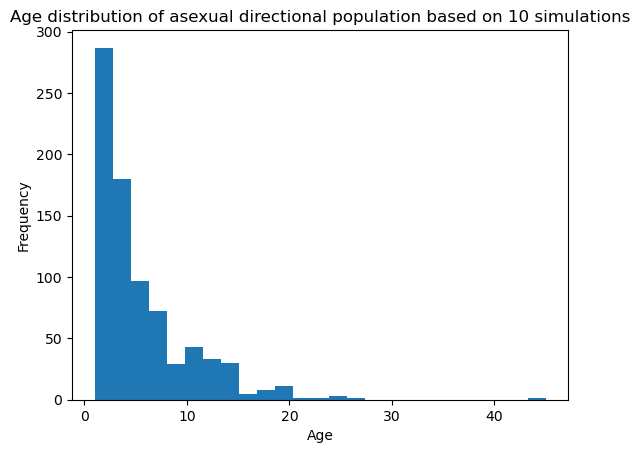

In [299]:
plt.hist(age_dist1, bins=25)
plt.title('Age distribution of asexual directional population based on 10 simulations')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.savefig('directional age distribution for 10x10 latice after 6000 generations, el buen0.jpg')

In [288]:
def count_elems(l):
    count = {}
    for num in l:
        if num in count:
            count[num] += 1
        else:
            count[num] = 1
    return count

In [289]:
#Make age_dist1 into proportions
age_count = count_elems(age_dist)
age_count1 = count_elems(age_dist1)

In [294]:
print(age_count)
print(age_count1)
print(len(age_dist), len(age_dist1))

{2: 149, 9: 25, 7: 50, 4: 74, 6: 51, 5: 73, 3: 109, 1: 147, 11: 16, 13: 10, 8: 42, 14: 8, 36: 1, 15: 6, 20: 6, 12: 17, 16: 8, 24: 1, 18: 7, 22: 4, 23: 4, 10: 20, 21: 3, 17: 4, 28: 1, 32: 1, 25: 2, 44: 1, 19: 1}
{2: 132, 11: 22, 4: 87, 9: 29, 3: 93, 7: 39, 22: 1, 1: 155, 16: 5, 17: 6, 5: 56, 12: 13, 27: 1, 14: 15, 6: 41, 24: 2, 8: 33, 13: 20, 10: 21, 45: 1, 15: 15, 25: 1, 19: 7, 18: 2, 20: 4, 23: 1}
841 802


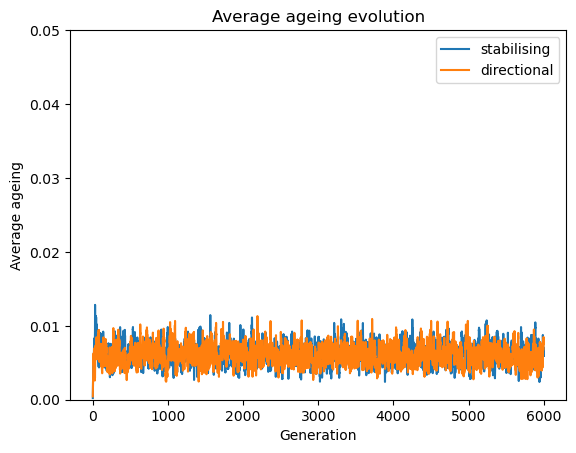

In [301]:
plt.plot(np.mean(means_directional, axis=0)[:, 1], label='stabilising')
plt.plot(np.mean(means_directional1, axis=0)[:, 1], label='directional')
plt.ylim(0, 0.05)
plt.legend()
plt.ylabel('Average ageing')
plt.xlabel('Generation')
plt.title('Average ageing evolution')

plt.savefig('Average ageing evolution.jpg')

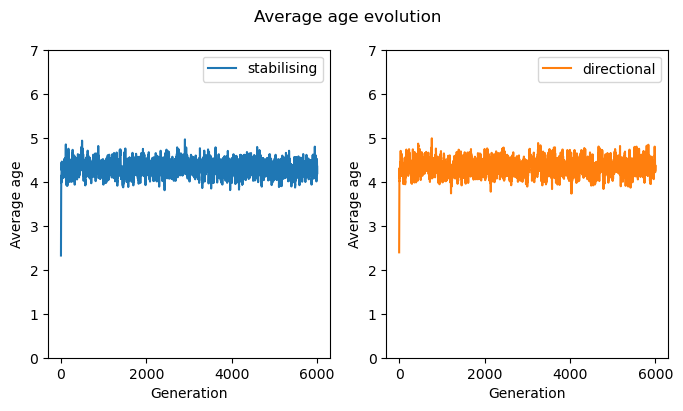

In [314]:
plt.figure(figsize=(8, 4))
plt.suptitle('Average age evolution')

plt.subplot(121)
plt.plot(np.mean(means_directional, axis=0)[:, 0], label='stabilising')
plt.ylabel('Average age')
plt.xlabel('Generation')
plt.ylim(0, 7)
plt.legend()


plt.subplot(122)
plt.plot(np.mean(means_directional1, axis=0)[:, 0], label='directional', color='#ff7f0e')
plt.ylabel('Average age')
plt.xlabel('Generation')
plt.ylim(0, 7)
plt.legend()

plt.savefig('Average age evolution.jpg')

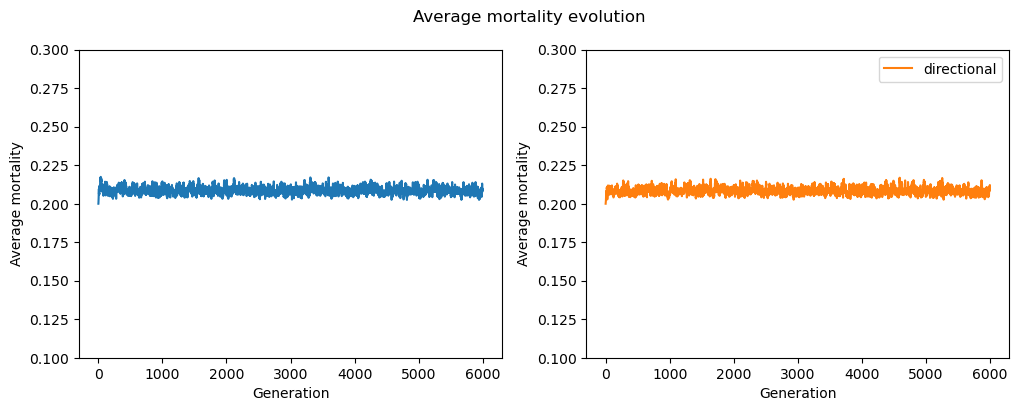

In [313]:
plt.figure(figsize=(12, 4))
plt.suptitle('Average mortality evolution')

plt.subplot(121)
plt.plot(np.mean(means_directional, axis=0)[:, 2], label='stabilising')
plt.ylabel('Average mortality')
plt.xlabel('Generation')
plt.ylim(0.1, 0.3)

plt.subplot(122)
plt.plot(np.mean(means_directional1, axis=0)[:, 2], label='directional', color='#ff7f0e')
plt.ylabel('Average mortality')
plt.xlabel('Generation')
plt.ylim(0.1, 0.3)
plt.legend()

plt.savefig('Average mortality evolution.jpg')

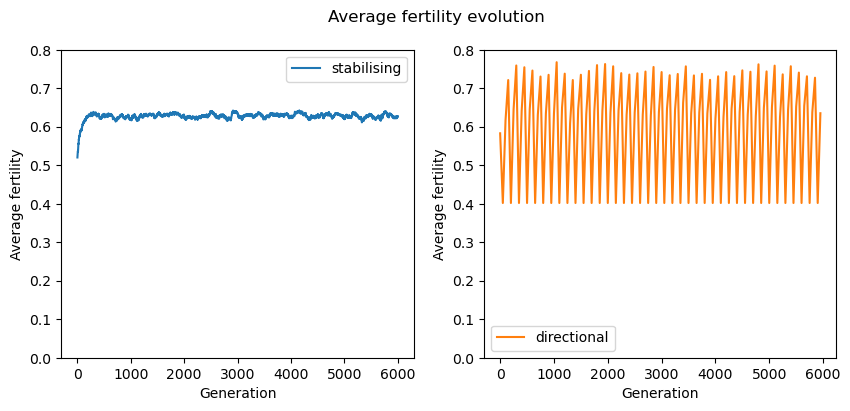

In [308]:
plt.figure(figsize=(10, 4))
plt.suptitle('Average fertility evolution')

plt.subplot(121)
plt.plot(np.mean(means_directional, axis=0)[:, 3], label='stabilising')
plt.ylabel('Average fertility')
plt.xlabel('Generation')
plt.ylim(0, 0.8)
plt.legend()

plt.subplot(122)
plt.plot(range(6000)[::50], np.mean(means_directional1, axis=0)[:, 3][::50], label='directional', color='#ff7f0e')
plt.ylabel('Average fertility')
plt.xlabel('Generation')
plt.ylim(0, 0.8)
plt.legend()

plt.savefig('Average fertility evollution.jpg')

#population is not changing fast enough. So that is why we see the very even fluctuations.

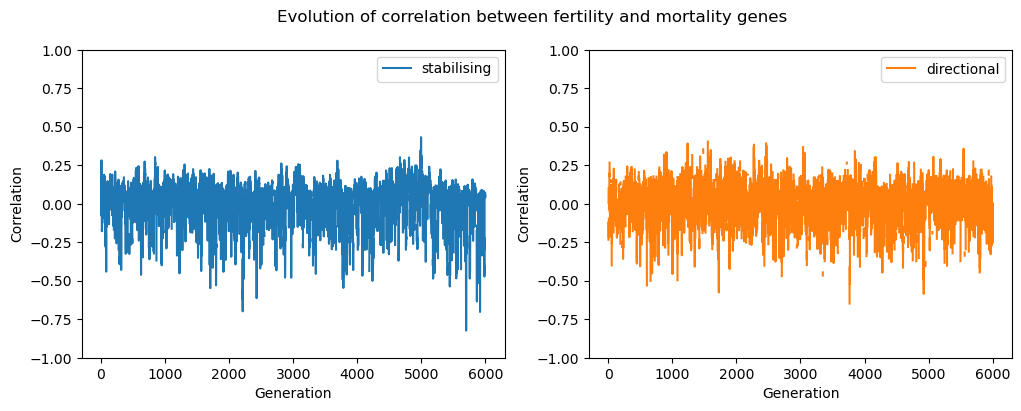

In [312]:
plt.figure(figsize=(12, 4))
plt.suptitle('Evolution of correlation between fertility and mortality genes')

plt.subplot(121)
plt.plot(corr, label='stabilising')
plt.xlabel('Generation')
plt.ylabel('Correlation')
plt.ylim(-1, 1)
plt.legend()

plt.subplot(122)
plt.plot(corr1, label='directional', color='#ff7f0e')
plt.ylabel('Correlation')
plt.xlabel('Generation')
plt.ylim(-1, 1)
plt.legend()

plt.savefig('Evolution of the correlation between fertility and mortality genes.jpg')

In [267]:
xbs1

[[1, 1, 0, 1, 1],
 [1, 1, 1, 1, 0],
 [1, 0, 0, 1, 1],
 [0, 1, 1, 1, 1],
 [1, 0, 1, 1, 0],
 [0, 1, 0, 1, 1],
 [0, 1, 1, 1, 1],
 [1, 1, 1, 1, 0],
 [1, 0, 1, 1, 0],
 [1, 1, 0, 1, 0],
 [1, 0, 1, 1, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 1, 1],
 [1, 1, 0, 1, 1],
 [1, 1, 0, 0, 0],
 [1, 1, 1, 1, 0],
 [1, 0, 0, 1, 0],
 [1, 0, 1, 1, 0],
 [1, 0, 1, 1, 1],
 [0, 1, 1, 1, 1],
 [1, 1, 0, 0, 0],
 [1, 0, 0, 0, 1],
 [0, 1, 1, 1, 0],
 [0, 1, 1, 1, 1],
 [0, 1, 1, 1, 1],
 [1, 0, 1, 1, 0],
 [1, 0, 0, 0, 1],
 [0, 1, 1, 1, 1],
 [1, 0, 0, 0, 1],
 [1, 1, 1, 0, 1],
 [1, 1, 1, 1, 0],
 [1, 0, 1, 1, 0],
 [1, 1, 0, 1, 1],
 [0, 0, 0, 0, 0],
 [0, 1, 0, 0, 1],
 [1, 1, 1, 1, 1],
 [0, 1, 1, 1, 1],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 1, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 1, 0],
 [0, 1, 0, 1, 1],
 [1, 0, 1, 1, 0],
 [1, 0, 1, 1, 0],
 [1, 0, 0, 1, 0],
 [1, 0, 1, 1, 0],
 [0, 1, 0, 1, 1],
 [0, 1, 0, 1, 1],
 [0, 1, 1, 1, 1],
 [1, 1, 0, 1, 1],
 [0, 1, 0, 0, 1],
 [0, 1, 1, 1, 1],
 [1, 1, 0, 1, 1],
 [1, 1, 1, 1, 0],
 [1, 1, 0, 1, 0],
 [1, 1, 0,

In [256]:
np.mean(np.mean(means_directional, axis=1), axis=0) #stabilising

array([4.31168583, 0.00615145, 0.20859309, 0.62735597])

In [257]:
np.mean(np.mean(means_directional1, axis=1), axis=0) #directional 

array([4.33051603, 0.00606242, 0.20843454, 0.40187757])

In [149]:
len([i for i in pop.flatten() if i is not None]) #calculates the amount of people left in the population

310

In [82]:
pop

array([[id: 4494641, age: 38, id: 4494611, age: 92, id: 4494655, age: 8,
        id: 4494650, age: 22, id: 4494658, age: 1, id: 4494646, age: 31,
        id: 4494648, age: 25, id: 4494619, age: 78, id: 4494652, age: 13,
        id: 4494657, age: 3],
       [None, None, None, id: 4494639, age: 42, None,
        id: 4494654, age: 10, None, id: 4494656, age: 7, None,
        id: 4494635, age: 48],
       [None, None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None, None]],
      dtype=object)

0

https://uomustansiriyah.edu.iq/media/lectures/6/6_2021_02_23!01_08_25_PM.pdf 


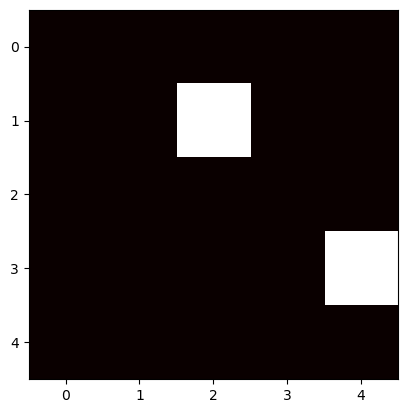

In [6]:
#Look up how we can plot this as a matrix
import matplotlib.pyplot as plt

# Example data: two tuples (x, y) and corresponding colors
data = [((1, 2), 'red'), ((3, 4), 'blue')]

# Create a 5x5 matrix filled with zeros (for example, 5x5 grid)
matrix = np.zeros((5, 5))

# Fill in the matrix with ones (or some other indicator) at the positions of the points
for point, color in data:
    x, y = point
    matrix[x, y] = 1
# Display the matrix as an image
plt.imshow(matrix, cmap='hot', interpolation='nearest')
#plt.colorbar()  # To show the scale
plt.show()

In [ ]:
#No furula
import numpy as np
import matplotlib.pyplot as plt

# Example data: two tuples (x, y) and corresponding colors
data = [((1, 2), 'red'), ((3, 4), 'blue')]

# Create a 5x5 matrix filled with white (or any default background color)
matrix = np.full((5, 5, 3), 255)  # RGB values, 255 means white

# Assign colors to the respective points
for point, color in data:
    x, y = point
    # Convert the color to RGB using matplotlib's color converter
    rgb_color = np.array(plt.cm.get_cmap("tab10")(plt.Normalize()(color))[:3]) * 255  # Normalize and convert to 0-255
    matrix[x, y] = rgb_color  # Set the RGB value at the respective (x, y)

# Display the matrix with the colors
plt.imshow(matrix)
plt.axis('off')  # Hide axis labels for better visualization
plt.show()


0

[3, 3]

hello
